In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
from scipy.signal import convolve2d

In [10]:
from scipy.optimize import fixed_point, root_scalar

In [11]:
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

# Finite differences updates

In [12]:
L=np.array([[0,1,0], [1, -4,1], [0,1,0]])

In [13]:
L=np.array([[1/4,1/2,1/4], [1/2, -3,1/2], [1/4,1/2,1/4]])

In [14]:
def update_rho(rho, m, v, D, dt, dx):
    #rho[rho<1e-3]=0
    return(rho 
           - v*(dt/dx)*(np.roll(m, axis=1,shift=-1)-np.roll(m, axis=1,shift=1))/2
           + D*(dt/(dx*dx))*convolve2d(rho, L, mode='same', boundary='wrap'))

In [15]:
def update_m(rho, m, v, D, beta, dt, dx):
    #rho[rho<1e-3]=0    
    return(m 
           - v*(dt/dx)*(np.roll(rho, axis=1,shift=-1)-np.roll(rho, axis=1,shift=1))/2
           + D*(dt/(dx*dx))*convolve2d(m, L, mode='same', boundary='wrap')
           + 2*dt*(beta-1-1/rho)*m 
           #+ 2*dt*(beta-1-np.divide(1, rho, where=rho!=0, out=np.zeros_like(rho)))*m 
           - dt*beta*beta*(1-beta/3)*m*m*m/(rho*rho)
          )

In [16]:
def update_X(X, v, D, beta, dt, dx, ly):
    rho, m = X[:ly, :], X[ly:, :]   
    
    drho = rho - v*(dt/dx)*(np.roll(m, axis=1,shift=-1)-np.roll(m, axis=1,shift=1))/2 + D*(dt/(dx*dx))*convolve2d(rho, L, mode='same', boundary='wrap')
    
    dm = m - v*(dt/dx)*(np.roll(rho, axis=1,shift=-1)-np.roll(rho, axis=1,shift=1))/2 + D*(dt/(dx*dx))*convolve2d(m, L, mode='same', boundary='wrap') + 2*dt*(beta-1-1/rho)*m- dt*beta*beta*(1-beta/3)*m*m*m/(rho*rho) 
       
    return(np.concatenate([drho, dm]))

# Phase diagram $(D, \rho_0)$

In [17]:
data_liq=pd.read_csv('D_rhol_ml.dat')
data_liq

,Unnamed: 0,D,rhol,ml
0,0,0.500000,3.631232,3.785692
1,1,0.555556,3.268990,3.335536
2,2,0.611111,3.008137,3.010155
3,3,0.666667,2.811184,2.763569
4,4,0.722222,2.656983,2.569792
5,5,0.777778,2.532751,2.413109
6,6,0.833333,2.430336,2.283482
7,7,0.888889,2.344303,2.174207
8,8,0.944444,2.270889,2.080640
9,9,1.000000,2.207406,1.999462


In [18]:
list_D=data_liq.D.values
rhol= data_liq.rhol
ml=data_liq.ml

In [19]:
def liq_th(beta, v, D):
    r=1
    phig=r/(beta-1)
    alpha=beta*beta*(1-beta/3)
    c=v*(1+(8*r*r*D)/(3*alpha*v*v*phig*phig))**(1/4)
    mlth=4*r*v/(3*alpha*c)
    rholth=phig - 4*r*v*v/(9*alpha*c*c) + v*mlth/c
    return([rholth, mlth])

In [20]:
rholth, mlth =  liq_th(beta=2, v=1, D=list_D)

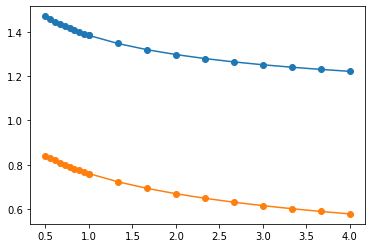

In [139]:

plt.plot(list_D, rholth, 'o-')
plt.plot(list_D, mlth, 'o-')

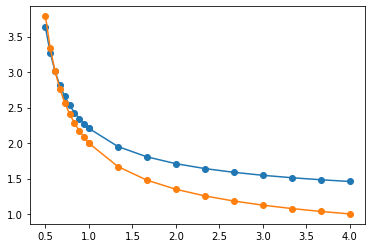

In [8]:
plt.plot(list_D, rhol, 'o-')
plt.plot(list_D, ml, 'o-')

Text(0, 0.5, '$D$')

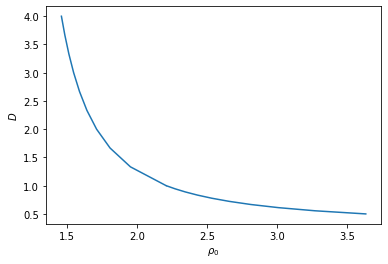

In [9]:
plt.plot(rhol, list_D, '-')
plt.xlabel(r'$\rho_0$')
plt.ylabel(r'$D$')
#plt.plot(list_D, ml, 'o-')

# Introduce Gaussian fluctuation in the liquid phase

In [10]:
def gaussianFluctH(lx, ly, h0):
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    dst = np.sqrt((x-lx/2)*(x-lx/2)+(y-ly/2)*(y-ly/2))

    sig=3
    gauss = h0*np.exp(-( (dst)**2 / ( 2.0 * sig**2 ) ) )
    return(gauss)

In [146]:
lx=600
ly=200
ds=1

tmax=100
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=1
beta=2

In [254]:
nD=19
D=list_D[nD]
print('D =', D)

rho=rhol[nD]*np.ones((ly,lx))
m=ml[nD]*np.ones((ly,lx))

h0=5
m-=3*m[0,0]*gaussianFluctH(lx, ly, h0)
rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, m])

D = 4.0


In [255]:
prof_rho=[]
prof_m=[]
prof_rho.append(rho.copy())
prof_m.append(m.copy())

for t in vec_t:
    X0=X.copy()
    
    X=update_X(X0, v, D, beta, dt, ds, ly)
    
    rho, m = X[:ly, :], X[ly:, :]  
    prof_rho.append(rho)
    prof_m.append(m)

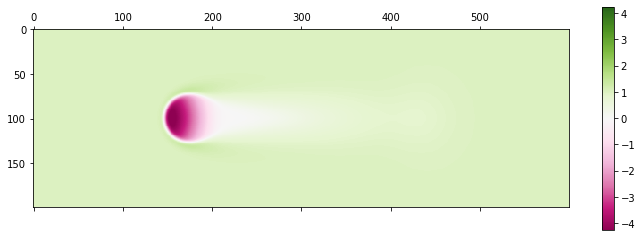

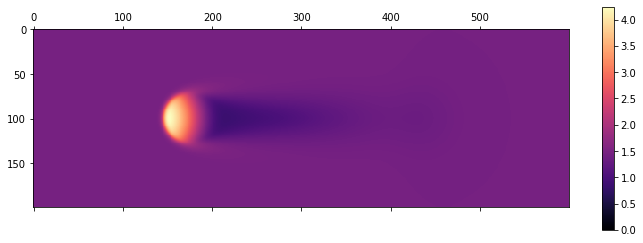

In [256]:
t=-1
mp=prof_m[t].copy()
rhop=prof_rho[t].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))

plt.matshow(mp, cmap='PiYG', vmin=-vmax, vmax=vmax)
plt.colorbar()

plt.matshow(rhop, cmap='magma', vmin=0, vmax=vmax)
plt.colorbar();


In [157]:
np.sum(p<0)/(lx*ly)

0.04658333333333333

In [261]:
len(prof_m)

1001

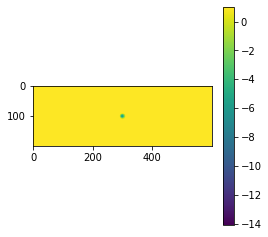

In [260]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(4, 4))

frame = 0

im = plt.imshow(prof_m[frame])
plt.colorbar()

def update(*args):
    global frame
    #print(frame)

    im.set_array(prof_m[frame])

    frame += 10
    frame %= len(prof_m)

    return im,

ani = animation.FuncAnimation(fig, update, len(prof_m))
writer = animation.ImageMagickFileWriter(fps=20)
ani.save('movie.gif', writer=writer) 

# Minimal Gaussian fluctuation to reverse the liquid phase

In [25]:
def gaussianFluctH(lx, ly, h0):
    x, y = np.meshgrid(np.arange(lx), np.arange(ly))
    dst = np.sqrt((x-lx/2)*(x-lx/2)+(y-ly/2)*(y-ly/2))

    sig=3
    gauss = h0*np.exp(-( (dst)**2 / ( 2.0 * sig**2 ) ) )
    return(gauss)

In [146]:
lx=600
ly=200
ds=1

tmax=100
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=1
beta=2

In [210]:
nD=0
D=list_D[nD]
print('D =', D)

rho=rhol[nD]*np.ones((ly,lx))
m=ml[nD]*np.ones((ly,lx))

h0=0.01
m-=3*m[0,0]*gaussianFluctH(lx, ly, h0)
rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, m])

D = 0.5


In [211]:
prof_rho=[]
prof_m=[]
prof_rho.append(rho.copy())
prof_m.append(m.copy())

frac=np.sum(m<0)/(lx*ly)

while((frac>0) and (frac<0.1)):
    X0=X.copy()
    
    X=update_X(X0, v, D, beta, dt, ds, ly)
    
    rho, m = X[:ly, :], X[ly:, :]  
    frac=np.sum(m<0)/(lx*ly)

    prof_rho.append(rho)
    prof_m.append(m)

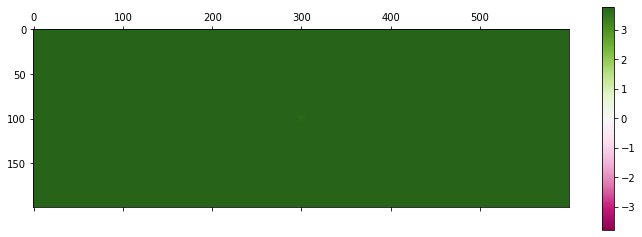

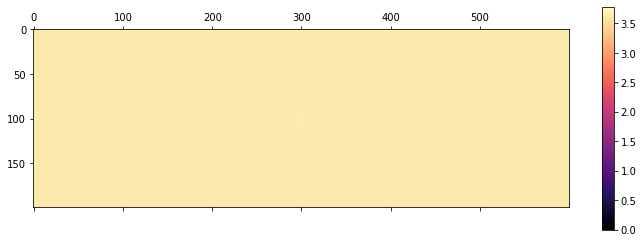

In [212]:
t=-1
mp=prof_m[t].copy()
rhop=prof_rho[t].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))

plt.matshow(mp, cmap='PiYG', vmin=-vmax, vmax=vmax)
plt.colorbar()

plt.matshow(rhop, cmap='magma', vmin=0, vmax=vmax)
plt.colorbar();


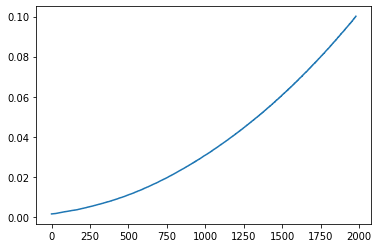

In [206]:
plt.plot([np.sum(p<0)/(lx*ly) for p in prof_m])

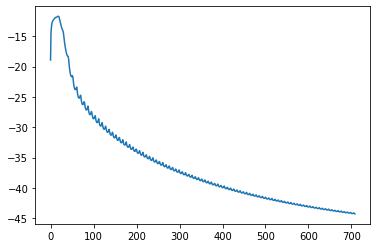

In [198]:
plt.plot([np.min(p[np.int64(ly/2),:]) for p in prof_m], '-')

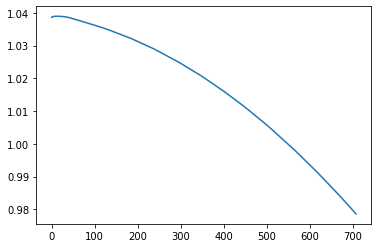

In [199]:
mag=np.array([np.sum(p) for p in prof_m])/np.sum(prof_rho[0])
plt.plot(mag)

In [187]:
def criterion_destab(h0, v, D, beta, rho0l, m0l, lx, ly):
    rho=rho0l*np.ones((ly,lx))
    m=m0l*np.ones((ly,lx))

    m-=3*m[0,0]*gaussianFluctH(lx, ly, h0)
    rho+=1*rho[0,0]*gaussianFluctH(lx, ly, h0)

    X=np.concatenate([rho, m])
    
    frac=np.sum(m<0)/(lx*ly)

    while((frac>0) and (frac<0.1)):
        X0=X.copy()

        X=update_X(X0, v, D, beta, dt, ds, ly)

        rho, m = X[:ly, :], X[ly:, :]  
        frac=np.sum(m<0)/(lx*ly)

    rho, m = X[:ly, :], X[ly:, :]  
    return(np.min(m[np.int64(ly/2),:]))

In [188]:
nD=3
criterion_destab(h0=10, v=1, D=list_D[nD], beta=2, rho0l=rhol[nD], m0l=ml[nD], lx=lx, ly=ly)

-28.499872159049183

In [191]:
nD=3
criterion_destab(h0=0.1, v=1, D=list_D[nD], beta=2, rho0l=rhol[nD], m0l=ml[nD], lx=lx, ly=ly)

1.9344985702188868

In [213]:
h0_crit=[]
for nD in range(len(list_D)):
    print(list_D[nD])
    h0_crit.append(root_scalar(criterion_destab, args=(1, list_D[nD], 2, rhol[nD], ml[nD], lx, ly), method='bisect', bracket=[0.01, 10]))

0.5
0.5555555555555556
0.6111111111111112
0.6666666666666667
0.7222222222222222
0.7777777777777778
0.8333333333333334
0.8888888888888888
0.9444444444444444
1.0
1.0
1.3333333333333333
1.6666666666666663
2.0
2.333333333333333
2.6666666666666665
3.0
3.333333333333333
3.6666666666666665
4.0


Text(0, 0.5, 'Critical fluctuation size')

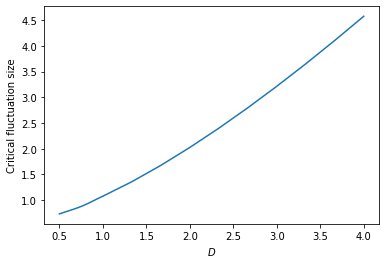

In [238]:
plt.plot(list_D, [h.root for h in h0_crit], '-')
#plt.plot(list_D, rhol, '-')

plt.xlabel(r'$D$')
plt.ylabel('Critical fluctuation size')

# $\vec{m}$

In [129]:
def update_X_vect(X, v, D, beta, dt, dx, ly):
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]   
    
    drho = rho\
    - v*(dt/dx)*(np.roll(my, axis=0,shift=-1)-np.roll(my, axis=0,shift=1))/2\
    - v*(dt/dx)*(np.roll(mx, axis=1,shift=-1)-np.roll(mx, axis=1,shift=1))/2\
    + D*(dt/(dx*dx))*convolve2d(rho, L, mode='same', boundary='wrap')
    
    norm_m=np.sqrt(mx*mx+my*my)
    
    dmx = mx\
    - v*(dt/dx)*(np.roll(rho, axis=1,shift=-1)-np.roll(rho, axis=1,shift=1))/2\
    + D*(dt/(dx*dx))*convolve2d(mx, L, mode='same', boundary='wrap')\
    + 2*dt*(beta-1-1/rho)*mx \
    - dt*beta*beta*(1-beta/3)*mx*norm_m*norm_m/(rho*rho) 
       
    dmy = my \
    - v*(dt/dx)*(np.roll(rho, axis=0,shift=-1)-np.roll(rho, axis=0,shift=1))/2 \
    + D*(dt/(dx*dx))*convolve2d(my, L, mode='same', boundary='wrap') \
    + 2*dt*(beta-1-1/rho)*my\
    - dt*beta*beta*(1-beta/3)*my*norm_m*norm_m/(rho*rho) 

    return(np.concatenate([drho, dmx, dmy]))

In [306]:
lx=200
ly=30
ds=1

tmax=1000
dt=0.1
vec_t=np.arange(0,tmax,dt)

v=1
beta=2

In [292]:
# INITIAL CONDITION : fluctuation in liq phase
nD=0
D=list_D[nD]
print('D =', D)

rho=rhol[nD]*np.ones((ly,lx))
mx=ml[nD]*np.ones((ly,lx))
my=np.zeros((ly,lx))


h0=10
mx-=3*mx[0,0]*gaussianFluctH(lx, ly, h0)
#my-=3*my[0,0]*gaussianFluctH(lx, ly, h0)

rho+=rho[0,0]*gaussianFluctH(lx, ly, h0)

X=np.concatenate([rho, mx, my])

D = 0.5


In [350]:
# INITIAL CONDITION : blob of particles in disordered gas
rhof=np.ones((ly,lx))
mxf=np.zeros((ly,lx))
myf=np.zeros((ly,lx))


r0=1.
rhof[:, :]+=r0*np.exp(-((np.arange(lx)-(lx/2))/50)**2)
mxf[:, :]=np.sqrt(2*rhof*rhof*(beta-1-1/rhof)/(beta*beta*(1-beta/3)))
X=np.concatenate([rhof, mxf, myf])

In [351]:
prof_rho=[]
prof_mx=[]
prof_my=[]

rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]
prof_rho.append(rho.copy())
prof_mx.append(mx.copy())
prof_my.append(my.copy())


for t in vec_t:
    X0=X.copy()
    
    X=update_X_vect(X0, v, D, beta, dt, ds, ly)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

In [352]:
# LAUNCH TO RESUME SIMU
for t in vec_t:
    X0=X.copy()
    
    X=update_X_vect(X0, v, D, beta, dt, ds, ly)
    
    rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    prof_rho.append(rho)
    prof_mx.append(mx)
    prof_my.append(my)

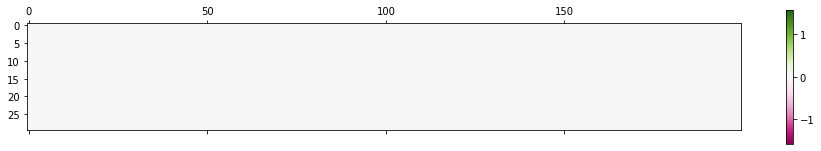

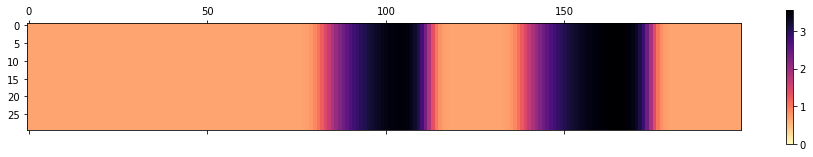

In [353]:
t=-1
mxp=prof_mx[t].copy()
myp=prof_my[t].copy()

rhop=prof_rho[t].copy()
vmax=np.max(rhop)

plt.matshow(np.arctan(myp, mxp), cmap='PiYG', vmin=-np.pi/2, vmax=np.pi/2)
plt.colorbar()

plt.matshow(rhop, cmap='magma_r', vmin=0, vmax=vmax)
plt.colorbar();


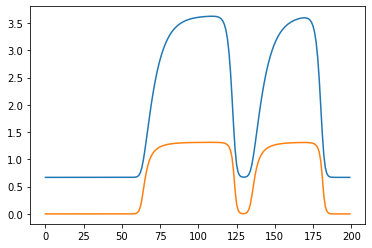

In [347]:
plt.plot(np.mean(rhop,0))
plt.plot(np.mean(np.arctan(myp, mxp),0))

In [274]:
import matplotlib.animation as animation

fig, ax = plt.subplots()
fig.set_size_inches(,1)

frame = 0

mp=prof_m[-1].copy()
rhop=prof_rho[-1].copy()
vmax=max(np.abs(np.max(mp)), np.max(rhop))
img = plt.imshow(prof_m[frame], cmap='PiYG', vmin=-vmax, vmax=vmax, aspect='equal')
plt.colorbar(shrink=0.9)

def update(*args):
    global frame
    #print(frame)

    img.set_array(prof_m[frame])

    frame += 40
    frame %= len(prof_m)

    return img,

ani = animation.FuncAnimation(fig, update, 160)
writer = animation.FFMpegWriter(fps=20)
ani.save('asympt_prof.avi', writer=writer) 

SyntaxError: invalid syntax (<ipython-input-274-6ea83e27f8fc>, line 4)

## $m_l, \rho_l$ 

In [356]:
def outputLastProfile(rho0, mx0, my0, tmax, dt, lx, ly, ds, v, beta, D):
    vec_t=np.arange(0,tmax,dt)
    X=np.concatenate([rho0, mx0, my0])
    
    for t in vec_t:
        X0=X.copy()

        X=update_X_vect(X0, v, D, beta, dt, ds, ly)

        rho, mx, my = X[:ly, :], X[ly:2*ly, :], X[2*ly:, :]  
    return(rho, mx, my)

In [ ]:
lx=500
ly=20

rhof=np.ones((ly,lx))
mxf=np.zeros((ly,lx))
myf=np.zeros((ly,lx))

r0=1.
rhof[:, :]+=r0*np.exp(-((np.arange(lx)-(lx/2))/50)**2)
mxf[:, :]=np.sqrt(2*rhof*rhof*(beta-1-1/rhof)/(beta*beta*(1-beta/3)))
X=np.concatenate([rhof, mxf, myf])

last_rho=[]
last_mx=[]
last_my=[]


list_D_2=np.linspace(0.5, 4.5, 20)
for D in list_D_2:
    print(D)
    rhof, mxf, myf = outputLastProfile(rho0=rhof, mx0=mxf, my0=myf, tmax=5000, dt=1e-1, lx=lx, ly=ly, ds=1, 
                             v=1, beta=2, D=D)
    last_rho.append(rhof)
    last_mx.append(mxf)
    last_my.append(myf)

0.5
0.7105263157894737
0.9210526315789473


In [ ]:
for nD in range(len(last_rho)):
    plt.plot(np.mean(last_rho[nD], axis=0), label=list_D[nD])
    plt.legend()

In [ ]:
plt.plot(np.mean(last_rho[-2], axis=0), label=list_D[-1])


In [ ]:
rhol_vec=[np.max(np.mean(last_rho[nD], axis=0)) for nD in range(len(last_rho))]
mxl_vec=[np.max(np.mean(last_mx[nD], axis=0)) for nD in range(len(last_rho))]
myl_vec=[np.max(np.mean(last_my[nD], axis=0)) for nD in range(len(last_rho))]

In [ ]:
plt.plot(list_D_2, rhol_vec,'o-')
plt.plot(list_D_2, mxl_vec,'o-')
#plt.plot(list_D_2, myl_vec,'o')